In [42]:
import tensorflow as tf
import os,shutil
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout,Flatten, Dense 
np.set_printoptions(threshold=np.inf)
from tensorflow.keras import Model

In [43]:
original_dataset_dir='D:/机器学习+毕设+java资料/吴恩达/cat vs dog/dc/train'
base_dir='D:/机器学习+毕设+java资料/吴恩达/cat vs dog/dc/find_cats_and_dogs'
train_dir=os.path.join(base_dir,'train')

validation_dir=os.path.join(base_dir,'validaiton')

test_dir=os.path.join(base_dir,'test')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')

test_dogs_dir = os.path.join(test_dir, 'dogs')

In [44]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 6000
total training dog images: 6000
total validation cat images: 2000
total validation dog images: 2000
total test cat images: 2000
total test dog images: 2000


In [46]:
from keras.preprocessing.image import ImageDataGenerator
#训练数据的增强
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # 目标目录
    target_size=(224,224),  # 大小调整
    batch_size=64,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=64,
    class_mode="binary"
)

Found 12000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [47]:
#数据增强处理
datagen = ImageDataGenerator(
    rotation_range=40,  # 0-180的角度值
    width_shift_range=0.2,  # 水平和垂直方向的范围；相对于总宽度或者高度的比例
    height_shift_range=0.2,
    shear_range=0.2,  # 随机错切变换的角度
    zoom_range=0.2,  # 图像随机缩放的角度
    horizontal_flip=True,  # 随机将一半图像进行水平翻转
    fill_mode="nearest"  # 用于填充新创建像素的方法
)

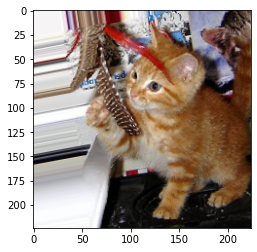

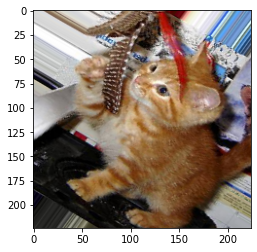

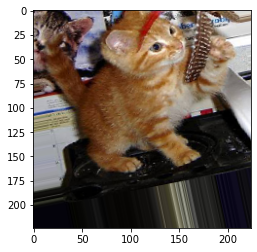

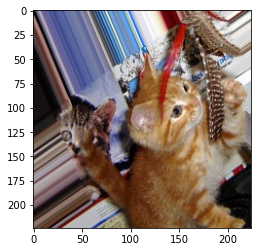

In [48]:
#数据增强
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir,fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[10]
# 读取图片并调整大小
img = image.load_img(img_path, target_size=(224,224))  
# 转成数组
x = image.img_to_array(img)

# shape转成(1,150,150,3)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):  # 生成随机变换后的图像批量
    plt.figure()   
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break  # 循环是无限，需要在某个时刻终止
        
plt.show()

In [49]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model=tf.keras.Sequential()
model.add(conv_base)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
conv_base.trainable = False	#冻结预训练模型的全部层

9420800/9406464 [==============================] - 2s 0us/step


In [50]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [51]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [53]:
checkpoint_save_path="./checkpoint/mobilenet.ckpt"
if os.path.exists(checkpoint_save_path+'.index'):
    print("--------加载模型---------")
    model.load_weights(checkpoint_save_path)
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                              save_weights_only=True,
                                              save_best_only=True)
history=model.fit(
      train_generator,
      steps_per_epoch=94,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=32,
    callbacks=[cp_callback])

Epoch 1/50
94/94 [==============================] - 46s 492ms/step - loss: 0.5003 - acc: 0.7697 - val_loss: 0.3269 - val_acc: 0.8945
Epoch 2/50
94/94 [==============================] - 46s 487ms/step - loss: 0.3469 - acc: 0.8630 - val_loss: 0.2252 - val_acc: 0.9375
Epoch 3/50
94/94 [==============================] - 46s 490ms/step - loss: 0.2752 - acc: 0.8959 - val_loss: 0.1789 - val_acc: 0.9468
Epoch 4/50
94/94 [==============================] - 46s 489ms/step - loss: 0.2266 - acc: 0.9147 - val_loss: 0.1563 - val_acc: 0.9556
Epoch 5/50
94/94 [==============================] - 45s 484ms/step - loss: 0.2127 - acc: 0.9191 - val_loss: 0.1403 - val_acc: 0.9575
Epoch 6/50
94/94 [==============================] - 45s 483ms/step - loss: 0.1940 - acc: 0.9266 - val_loss: 0.1265 - val_acc: 0.9639
Epoch 7/50
94/94 [==============================] - 46s 485ms/step - loss: 0.1862 - acc: 0.9269 - val_loss: 0.1069 - val_acc: 0.9688
Epoch 8/50
94/94 [==============================] - 46s 486ms/step - 

Text(0.5, 1.0, 'Training and validation loss')

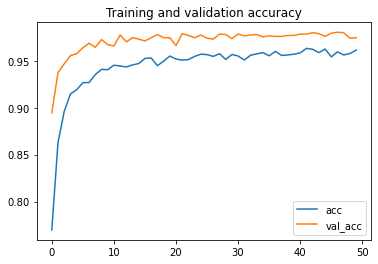

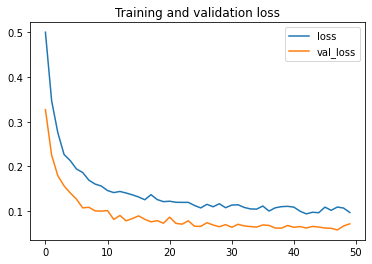

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc))
plt.plot  ( epochs,     acc ,label='acc')
plt.plot  ( epochs, val_acc ,label='val_acc')
plt.legend(loc='best')
plt.title ('Training and validation accuracy')
plt.figure()
plt.plot  ( epochs,     loss ,label='loss')
plt.plot  ( epochs, val_loss ,label='val_loss')
plt.legend(loc='best')
plt.title ('Training and validation loss')

In [ ]:
model.save("cats_and_dogs_mobile.h5")